# 可视化模型的 Scale&Shift 参数
## ViT-b16

In [1]:
import sys
import os

sys.path.append("/home/wyh/PEFT/SSF")
import torch
import timm
from timm.models import create_model, safe_model_name, resume_checkpoint, load_checkpoint,\
    convert_splitbn_model, model_parameters
from models import vision_transformer, swin_transformer, convnext, as_mlp



In [2]:
MODEL_NAME="vit_base_patch16_224_in21k"
MODEL_PATH="./vit_base_patch16_224_in21k/cifar_100/ssf/20230521-144333-vit_base_patch16_224_in21k-224/model_best.pth.tar"
METHOD_NAME="ssf"
NUM_CLASSES=100

In [3]:

model = create_model(
    MODEL_NAME,
    pretrained=True,
    num_classes=NUM_CLASSES,
    drop_rate=0.0,
    drop_path_rate=0.0,
    drop_block_rate=None,
    global_pool=None,
    bn_momentum=None,
    bn_eps=None,
    scriptable=False,
    checkpoint_path='',
    tuning_mode=METHOD_NAME)
resume_epoch = resume_checkpoint(
    model, MODEL_PATH,
    optimizer=None,
    loss_scaler=None,
    log_info=True)


In [4]:
for i,(name,module) in enumerate(model.named_modules()) :
    # print(name)
    cw=False
    for m in module.children():
        if hasattr(m,"weight"):
            cw=True
    if cw:
    # if hasattr(module,"weight"):
        print(i,"\t",name)
        print("PARAMETER: ")
        for n,p in module.named_parameters():
            print(n,"\t",p.shape)
        print("DICT:")
        # print(type(module.weight),module.weight.size())
        for k in module.__dict__:
            print("\t",k)
        
        
    

0 	 
PARAMETER: 
cls_token 	 torch.Size([1, 1, 768])
pos_embed 	 torch.Size([1, 197, 768])
ssf_scale_1 	 torch.Size([768])
ssf_shift_1 	 torch.Size([768])
patch_embed.ssf_scale_1 	 torch.Size([768])
patch_embed.ssf_shift_1 	 torch.Size([768])
patch_embed.proj.weight 	 torch.Size([768, 3, 16, 16])
patch_embed.proj.bias 	 torch.Size([768])
blocks.0.ssf_scale_1 	 torch.Size([768])
blocks.0.ssf_shift_1 	 torch.Size([768])
blocks.0.ssf_scale_2 	 torch.Size([768])
blocks.0.ssf_shift_2 	 torch.Size([768])
blocks.0.norm1.weight 	 torch.Size([768])
blocks.0.norm1.bias 	 torch.Size([768])
blocks.0.attn.ssf_scale_1 	 torch.Size([2304])
blocks.0.attn.ssf_shift_1 	 torch.Size([2304])
blocks.0.attn.ssf_scale_2 	 torch.Size([768])
blocks.0.attn.ssf_shift_2 	 torch.Size([768])
blocks.0.attn.qkv.weight 	 torch.Size([2304, 768])
blocks.0.attn.qkv.bias 	 torch.Size([2304])
blocks.0.attn.proj.weight 	 torch.Size([768, 768])
blocks.0.attn.proj.bias 	 torch.Size([768])
blocks.0.norm2.weight 	 torch.Size([76

In [5]:
ssf_scale,ssf_shift={},{}
for name, para in model.named_parameters():
    if "ssf_scale" in name:
        ssf_scale[name]=para.data.detach().cpu().numpy()
    elif "ssf_shift" in name:
        ssf_shift[name]=para.data.detach().cpu().numpy()
    else:
        pass

In [6]:
# show basic info of ssf_scale and ssf_shift:
print("Length: ",len(ssf_scale),"\t",len(ssf_shift))
print("SSF_SCALE:")
for k in ssf_scale:
    print(k,ssf_scale[k].shape)
print("SSF_SHIFT:")
for k in ssf_shift:
    print(k,ssf_shift[k].shape)

Length:  74 	 74
SSF_SCALE:
ssf_scale_1 (768,)
patch_embed.ssf_scale_1 (768,)
blocks.0.ssf_scale_1 (768,)
blocks.0.ssf_scale_2 (768,)
blocks.0.attn.ssf_scale_1 (2304,)
blocks.0.attn.ssf_scale_2 (768,)
blocks.0.mlp.ssf_scale_1 (3072,)
blocks.0.mlp.ssf_scale_2 (768,)
blocks.1.ssf_scale_1 (768,)
blocks.1.ssf_scale_2 (768,)
blocks.1.attn.ssf_scale_1 (2304,)
blocks.1.attn.ssf_scale_2 (768,)
blocks.1.mlp.ssf_scale_1 (3072,)
blocks.1.mlp.ssf_scale_2 (768,)
blocks.2.ssf_scale_1 (768,)
blocks.2.ssf_scale_2 (768,)
blocks.2.attn.ssf_scale_1 (2304,)
blocks.2.attn.ssf_scale_2 (768,)
blocks.2.mlp.ssf_scale_1 (3072,)
blocks.2.mlp.ssf_scale_2 (768,)
blocks.3.ssf_scale_1 (768,)
blocks.3.ssf_scale_2 (768,)
blocks.3.attn.ssf_scale_1 (2304,)
blocks.3.attn.ssf_scale_2 (768,)
blocks.3.mlp.ssf_scale_1 (3072,)
blocks.3.mlp.ssf_scale_2 (768,)
blocks.4.ssf_scale_1 (768,)
blocks.4.ssf_scale_2 (768,)
blocks.4.attn.ssf_scale_1 (2304,)
blocks.4.attn.ssf_scale_2 (768,)
blocks.4.mlp.ssf_scale_1 (3072,)
blocks.4.mlp.s

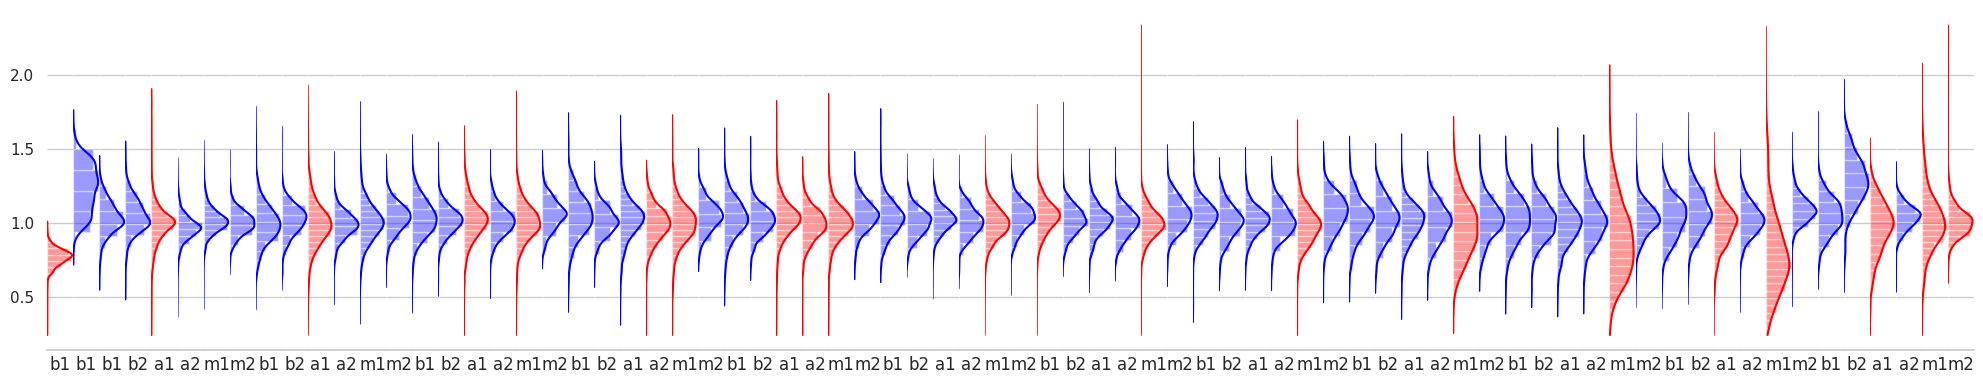

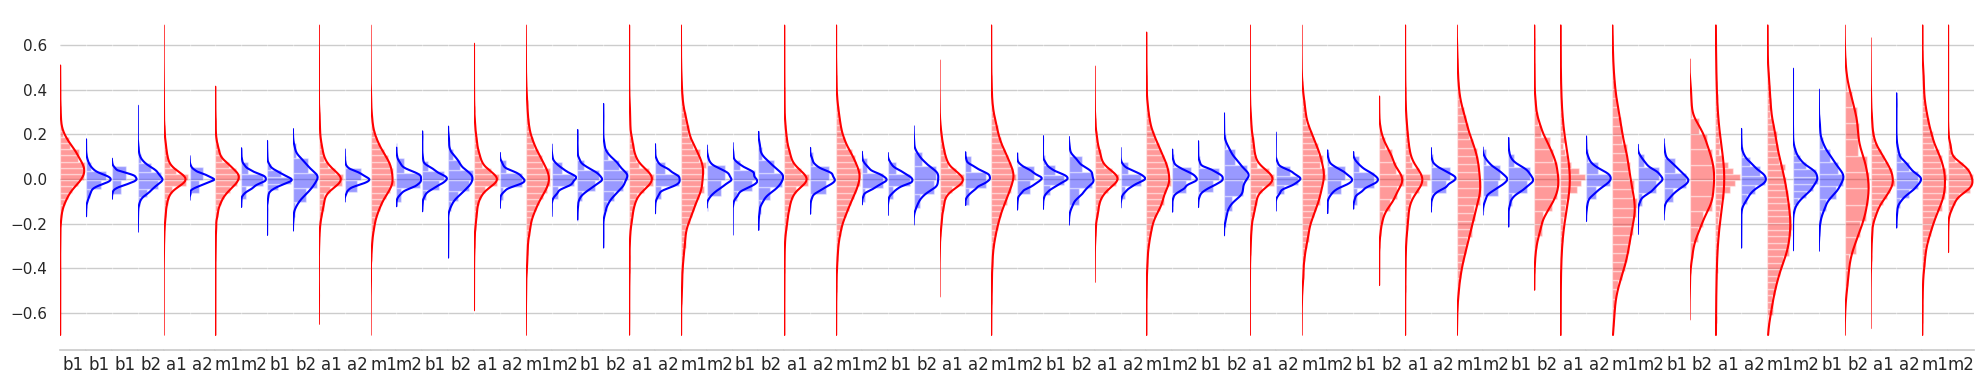

MAX Scale:  2.82148
MIN Scale:  -0.13894247
MAX Shift:  4.5410037
MIN Shift:  -3.692833


In [9]:
import warnings
warnings. filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision.models as models

def draw6(row1,name=None):
    data=row1
    arr = data
    up_mean=np.mean(np.array([a.max() for a in arr]))
    lw_mean=np.mean(np.array([a.min() for a in arr]))
    num_rows = len(arr)
    fig, axs = plt.subplots(ncols=num_rows, nrows=1, sharey=True,gridspec_kw={"hspace": 0, "wspace": 0})
    fig.set_size_inches(20, 4)
    lw=lw_mean*1.5 if lw_mean<0 else lw_mean*0.5
    ran=(lw,up_mean*1.5)
    for i in range(num_rows):
        # sns.histplot(y=arr[i], ax=axs[i], kde=True, stat="density")
        # sns.distplot(arr[i], ax=axs[i], kde=True, stat="density",hist_kws={'range': (0.0, 0.2)})
        color="blue"
        if arr[i].max() > up_mean*1.2 or arr[i].min() < lw_mean*0.8:
            color="red"
        sns.distplot(arr[i], ax=axs[i], kde=True, vertical=True,color=color,\
            hist_kws={'range': ran},kde_kws={'clip': ran})
        # sns.histplot(data, clip=(0, 10))
        axs[i].set_xticks([])
        # axs[i].set_xlabel(f"{i+1}")
        label=""
        if 'attn' in name[i]:
            label+="a"
        elif 'mlp' in name[i]:
            label+="m"
        else:
            label+="b"
        label+=name[i].split("_")[-1]
        axs[i].set_xlabel(label)
    plt.tight_layout()
    # sns.set_style('white')
    sns.set(style='whitegrid')
    sns.despine(right=True,left=True)
    plt.show()
ssf_scale_list,ssf_shift_list,ssf_scale_name,ssf_shift_name=[],[],[],[]
for name, para in model.named_parameters():
    if "ssf_scale" in name:
        ssf_scale_list.append(para.data.detach().cpu().numpy())
        ssf_scale_name.append(name)
    elif "ssf_shift" in name:
        ssf_shift_list.append(para.data.detach().cpu().numpy())
        ssf_shift_name.append(name)
    else:
        pass
draw6(ssf_scale_list,ssf_scale_name)
draw6(ssf_shift_list,ssf_shift_name)
print("MAX Scale: ", max([s.max() for s in ssf_scale_list]))
print("MIN Scale: ", min([s.min() for s in ssf_scale_list]))
print("MAX Shift: ", max([s.max() for s in ssf_shift_list]))
print("MIN Shift: ", min([s.min() for s in ssf_shift_list]))

In [12]:
def print_outler(row1,name=None):
    data=row1
    arr = data
    up_mean=np.mean(np.array([a.max() for a in arr]))
    lw_mean=np.mean(np.array([a.min() for a in arr]))
    num_rows = len(arr)
    lw=lw_mean*1.5 if lw_mean<0 else lw_mean*0.5
    ran=(lw,up_mean*1.5)
    for i in range(len(row1)):
        if arr[i].max() > up_mean*1.2 or arr[i].min() < lw_mean*0.8:
            print(name[i])
print_outler(ssf_scale_list,ssf_scale_name)
print_outler(ssf_shift_list,ssf_shift_name)


ssf_scale_1
blocks.0.attn.ssf_scale_1
blocks.1.attn.ssf_scale_1
blocks.2.attn.ssf_scale_1
blocks.2.mlp.ssf_scale_1
blocks.3.attn.ssf_scale_2
blocks.3.mlp.ssf_scale_1
blocks.4.attn.ssf_scale_1
blocks.4.attn.ssf_scale_2
blocks.4.mlp.ssf_scale_1
blocks.5.mlp.ssf_scale_1
blocks.6.ssf_scale_1
blocks.6.mlp.ssf_scale_1
blocks.7.mlp.ssf_scale_1
blocks.8.mlp.ssf_scale_1
blocks.9.mlp.ssf_scale_1
blocks.10.attn.ssf_scale_1
blocks.10.mlp.ssf_scale_1
blocks.11.attn.ssf_scale_1
blocks.11.mlp.ssf_scale_1
blocks.11.mlp.ssf_scale_2
ssf_shift_1
blocks.0.attn.ssf_shift_1
blocks.0.mlp.ssf_shift_1
blocks.1.attn.ssf_shift_1
blocks.1.mlp.ssf_shift_1
blocks.2.attn.ssf_shift_1
blocks.2.mlp.ssf_shift_1
blocks.3.attn.ssf_shift_1
blocks.3.mlp.ssf_shift_1
blocks.4.attn.ssf_shift_1
blocks.4.mlp.ssf_shift_1
blocks.5.attn.ssf_shift_1
blocks.5.mlp.ssf_shift_1
blocks.6.attn.ssf_shift_1
blocks.6.mlp.ssf_shift_1
blocks.7.attn.ssf_shift_1
blocks.7.mlp.ssf_shift_1
blocks.8.ssf_shift_2
blocks.8.attn.ssf_shift_1
blocks.8.mlp

# 运行计时
5.23 00:35 开始运行 ./train_scripts/vit/cifar_vtab